## Predict Spend

Given the historic data with clicks, impressions, spend, reach, and so on, build a model that can predict the probability of a specific _spend_ will result in clicks, impressions, reach, and so on.

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

In [3]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
# import tensorflow_probability as tfp
# import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.etl.loader import sparkFile as file
# from rezaware.modules.etl.loader import __propAttr__ as attr

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write dataset for MCMC sampling"

clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write dataset for MCMC sampling class initialization and load complete!


## Load Data

In [4]:
options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

_fpath = "mining/data/budget/"
_fname = "FullDataset.csv"
sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path=_fpath,  # optional - relative path, w.r.t. self.storeRoot
    file_name=_fname,  # optional - name of the file to read (complete-60-accounts.csv)
    file_type=None,  # optional - read all the files of same type
    **options,
)
print("Loaded %s %d rows" % (_fname, sdf.count()))# sdf.printSchema()
''' convert date to int '''
sdf = sdf.withColumn('date', F.unix_timestamp('updated_time'))
print("timestamp converted unix_timestamp for %d rows" % sdf.count())

25/03/04 15:29:30 WARN Utils: Your hostname, FarmRaider2 resolves to a loopback address: 127.0.1.1; using 192.168.2.85 instead (on interface enp3s0)
25/03/04 15:29:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/04 15:29:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/04 15:29:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
                                                                                

Loaded FullDataset.csv 1777681 rows


[Stage 14:==============================================>           (4 + 1) / 5]

timestamp converted unix_timestamp for 1777681 rows


In [5]:
sdf.groupBy('objective').count().orderBy('count', ascending=False).show()

[Stage 17:==============================================>           (4 + 1) / 5]

+--------------------+-------+
|           objective|  count|
+--------------------+-------+
|       OUTCOME_SALES|1504435|
|         LINK_CLICKS|  71717|
|         CONVERSIONS|  59053|
|       OUTCOME_LEADS|  58280|
|  OUTCOME_ENGAGEMENT|  33818|
|   OUTCOME_AWARENESS|  20332|
|PRODUCT_CATALOG_S...|  16081|
|        APP_INSTALLS|  10753|
|     LEAD_GENERATION|   1145|
|            MESSAGES|    944|
|     POST_ENGAGEMENT|    910|
|         VIDEO_VIEWS|    127|
|               REACH|     81|
|          PAGE_LIKES|      4|
|     BRAND_AWARENESS|      1|
+--------------------+-------+



## Filtered Dataframe
* goal = OFFSITE_CONVERSIONS
* columns = spend_usd, CPC, CPM, CTR, ROAS,<br><tab><tab>click, impressions, frequency, reach
* column value >= mean + 2 x sigma (95 percentile)
* account_currency = USD (market segment)

In [6]:
__def_obj__ = 'OUTCOME_LEADS'

# __def_obs_cols__= ['spend','impressions', 'clicks', 'reach', 'frequency']
# __def_dt_cols__ = ['date']

obj_sdf=sdf.filter(F.col('objective').isin(__def_obj__))
null_counts = obj_sdf.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in obj_sdf.columns]).collect()[0].asDict()
to_drop = [k for k, v in null_counts.items() if v >= obj_sdf.count()]
obj_sdf = obj_sdf.drop(*to_drop)
print("Filtered %d rows and reduced to %d of %d columns" 
      % (obj_sdf.count(), len(obj_sdf.columns), len(sdf.columns)))

25/03/04 15:30:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 416:=============================================>           (4 + 1) / 5]

Filtered 58280 rows and reduced to 44 of 131 columns


In [7]:
obj_sdf.printSchema()

root
 |-- account_id: long (nullable = true)
 |-- ad_id: long (nullable = true)
 |-- adset_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- reach: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPP: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- objective: string (nullable = true)
 |-- account_currency: string (nullable = true)
 |-- business_country_code: string (nullable = true)
 |-- business_city: string (nullable = true)
 |-- business_state: string (nullable = true)
 |-- timezone_name: string (nullable = true)
 |-- d1_view: double (nullable = true)
 |-- d7_view: double (nullable = true)
 |-- d28_view: double (nullable = true)
 |-- d1_click: double (nullable = true)
 |-- d7_click: double (n

In [8]:
__def_obj_col__ = 'objective'
__def_opt_goal__= 'checkout'  # action group
__def_dt_cols__ = ['date', 'updated_time']
__def_ad_met_cols__ = ['spend','impressions', 'clicks', 'reach', 
                       'frequency', 'CTR', 'CPP', 'CPC', 'CPM']
__def_roas_cols__ = ['purchase_value', 'purchase_roas']

_goal_act_cols = [x for x in obj_sdf.columns
                  if x.find(__def_opt_goal__)==0
                  and x not in [*__def_ad_met_cols__, 
                                *__def_dt_cols__,
                                *__def_roas_cols__]]

''' Remove goal action cols not greater than zero '''
count_dict= {}
for act  in _goal_act_cols:
    count_dict[act]=obj_sdf.select(act).dropna().count()

_act_met_cols_lst = [k for k,v in count_dict.items() if v>0]
_act_met_cols_lst

['checkout_offsite_conversion__fb_pixel_add_to_cart',
 'checkout_offsite_conversion__fb_pixel_initiate_checkout',
 'checkout_offsite_conversion__fb_pixel_add_payment_info']

In [9]:
''' select data for relevant columns '''
_obj_goal_sdf=obj_sdf.select(*__def_dt_cols__, __def_obj_col__,
                             *__def_roas_cols__, *__def_ad_met_cols__,
                             *_act_met_cols_lst)\
                    .orderBy(*__def_dt_cols__)

_obj_goal_sdf.printSchema()

root
 |-- date: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- objective: string (nullable = true)
 |-- purchase_value: double (nullable = true)
 |-- purchase_roas: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- reach: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPP: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- checkout_offsite_conversion__fb_pixel_add_to_cart: double (nullable = true)
 |-- checkout_offsite_conversion__fb_pixel_initiate_checkout: double (nullable = true)
 |-- checkout_offsite_conversion__fb_pixel_add_payment_info: double (nullable = true)



## Hamiltonian Monte Carlo for MCMC sampline
* Use Gaussian Process (GP) to model complex time-dependent patterns
* How to Incorporate DateTime into the Bayesian Model? To capture the effect of time in ad performance, you can:
   * Add a Time-Varying Component (Temporal Effects).
   * Treat time (e.g., days_since_start) as a continuous variable.
   * Model seasonality or trends using a Gaussian Process (GP) or a hierarchical time-series structure.

In [18]:
import numpy as np

clicks = np.array([x['clicks'] for x in _obj_goal_sdf.select('clicks').collect()]).astype(np.float32)
clicks.shape

(58280,)

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

# Simulated Ad Performance Data
# spend = np.array([x['spend'] for x in _obj_goal_sdf.select('spend').collect()]).astype(np.float32)
spend = np.array([100, 200, 300, 400, 500], dtype=np.float32)  # Ad spend per campaign
# clicks = np.array([x['clicks'] for x in _obj_goal_sdf.select('clicks').collect()]).astype(np.float32)
clicks = np.array([50, 150, 300, 450, 600], dtype=np.float32)  # Observed clicks
conversions = np.array([5, 20, 45, 80, 110], dtype=np.float32)  # Observed conversions

# Define Bayesian Model
def model():
    # Priors
    alpha = yield tfd.Gamma(concentration=2.0, rate=2.0, name="alpha")  # Click rate shape
    ctr = yield tfd.Beta(concentration1=2.0, concentration0=5.0, name="ctr")  # Conversion rate

    # Click Model (Poisson)
    lambda_clicks = spend * alpha
    clicks_pred = yield tfd.Poisson(rate=lambda_clicks, name="clicks_pred")

    # Conversion Model (Binomial)
    conversions_pred = yield tfd.Binomial(total_count=clicks_pred, probs=ctr, name="conversions_pred")

# MCMC Inference using Hamiltonian Monte Carlo (HMC)
def run_mcmc():
    model_joint = tfd.JointDistributionCoroutine(model)

    # Observed data
    def target_log_prob_fn(alpha, ctr):
        return model_joint.log_prob(alpha, ctr, clicks, conversions)

    # HMC sampler
    num_results = 2000
    num_burnin_steps = 500

    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn, step_size=0.1, num_leapfrog_steps=3
    )

    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[tf.constant(1.0), tf.constant(0.1)],  # Initial values for alpha & ctr
        kernel=kernel
    )

    return samples

# Run MCMC
samples = run_mcmc()

# Plot results
plt.hist(samples[0], bins=30, alpha=0.6, label="Alpha (Click Rate)")
plt.hist(samples[1], bins=30, alpha=0.6, label="CTR (Conversion Rate)")
plt.legend()
plt.show()


In [1]:
_plot_df = _obj_goal_sdf.groupBy('date')\
                        .sum(*_act_met_cols_lst)\
                        .orderBy('date').toPandas()

for col in _act_met_cols_lst:
    _plot_df.rename(columns={f"sum({col})" : col}, inplace=True)
    _plot_df[col].fillna(0, inplace=True)
_plot_df

NameError: name '_obj_goal_sdf' is not defined

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()
scaled_arr = scaler.fit_transform(_plot_df[_act_met_cols_lst])
scaled_arr

array([[9.37495635e-07, 6.05960405e-04, 1.57423830e-02],
       [4.31600239e-06, 2.55332090e-01, 1.89349113e-02],
       [2.17828436e-06, 7.86019924e-05, 1.10635031e-01],
       [5.64449338e-07, 5.37139148e-05, 4.88539078e-05],
       [5.83393251e-07, 3.35899590e-05, 6.29119751e-04],
       [6.18729918e-07, 2.31401675e-04, 8.32152986e-03],
       [1.00000000e+00, 1.13202009e-04, 5.19076931e-02],
       [6.80268877e-07, 6.09142365e-05, 8.17157021e-03],
       [1.06622809e-06, 4.21536440e-03, 2.53092714e-02],
       [5.31499361e-06, 1.33116559e-04, 1.82910435e-01],
       [9.21398593e-07, 3.50233770e-05, 8.59839179e-03],
       [3.40832010e-07, 4.07962080e-01, 1.74572106e-03],
       [8.76555827e-06, 1.00000000e+00, 4.72266028e-01],
       [2.06757236e-06, 1.61512889e-03, 1.74369791e-02],
       [1.22107365e-05, 1.42476138e-03, 1.00000000e+00],
       [5.47567397e-08, 2.87349081e-05, 2.66488359e-02],
       [2.73860367e-06, 2.27150568e-04, 1.59766841e-02],
       [9.15063955e-08, 9.20999

In [18]:
scaled_arr=np.array(_plot_df[_act_met_cols_lst])
scaled_arr

array([[4.67780930e+05, 2.74321082e+06, 9.08055000e+03],
       [2.13000527e+06, 1.15590020e+09, 1.09220700e+04],
       [1.07824862e+06, 3.55834860e+05, 6.38167000e+04],
       [2.84242260e+05, 2.43165380e+05, 2.81800000e+01],
       [2.93562660e+05, 1.52063300e+05, 3.62890000e+02],
       [3.10948290e+05, 1.04756610e+06, 4.80004000e+03],
       [4.91999716e+11, 5.12470740e+05, 2.99414900e+04],
       [3.41225440e+05, 2.75761570e+05, 4.71354000e+03],
       [5.31117260e+05, 1.90831499e+07, 1.45989400e+04],
       [2.62150866e+06, 6.02624830e+05, 1.05506730e+05],
       [4.59861190e+05, 1.58552450e+05, 4.95974000e+03],
       [1.74222600e+05, 1.84686323e+09, 1.00697000e+03],
       [4.31918547e+06, 4.52704632e+09, 2.72413350e+05],
       [1.02377835e+06, 7.31176331e+06, 1.00580300e+04],
       [6.01421218e+06, 6.44996074e+06, 5.76821820e+05],
       [3.34736500e+04, 1.30084260e+05, 1.53716300e+04],
       [1.35392556e+06, 1.02832114e+06, 9.21570000e+03],
       [5.15544700e+04, 4.16940

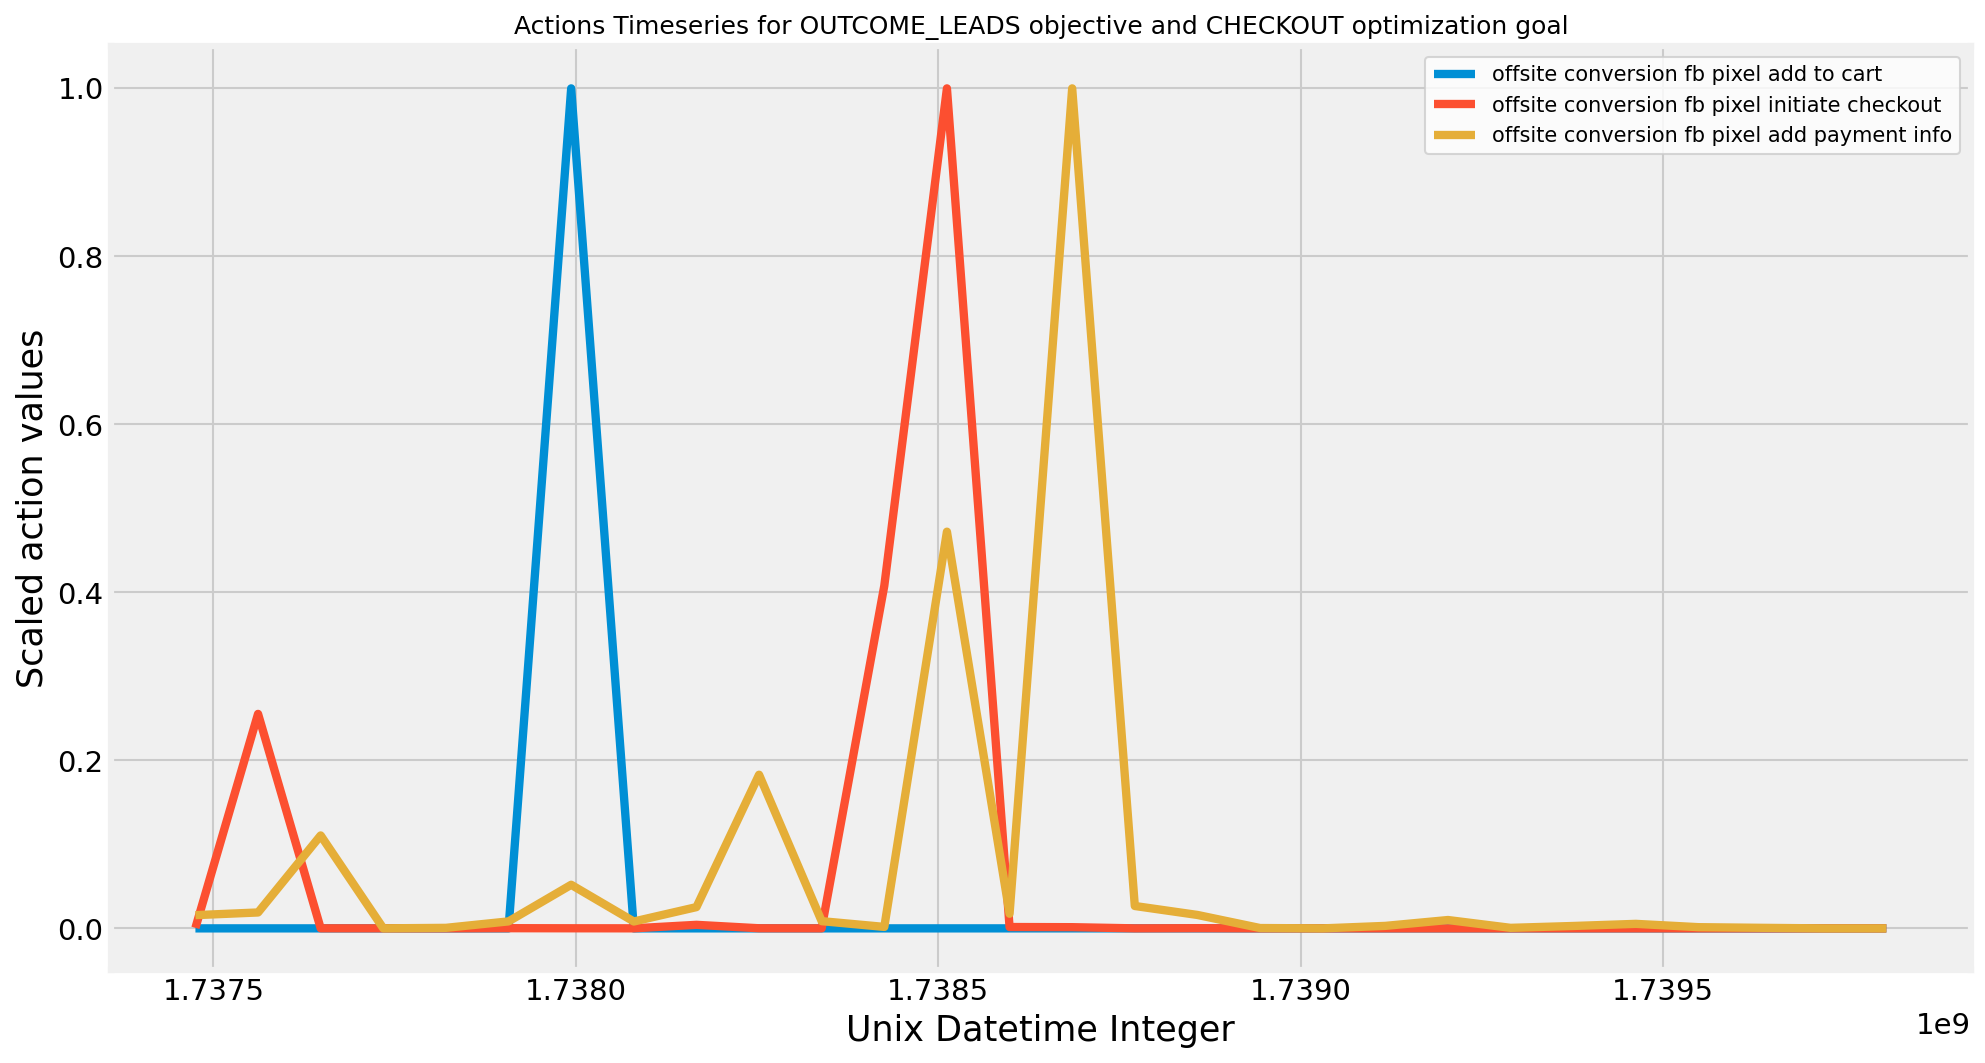

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 8), dpi=150) 
with plt.style.context('fivethirtyeight'):
    for i in range(0,scaled_arr.shape[1],1):
        plt.plot(_plot_df['date'], scaled_arr[:,i])

plt.title(f"Actions Timeseries for {__def_obj__} objective and {__def_opt_goal__.upper()}"+\
          " optimization goal")
plt.xlabel('Unix Datetime Integer')
plt.ylabel('Scaled action values')
leg = [x.replace('__'," ").replace("_"," ").split(' ', 1)[1] for x in _act_met_cols_lst]
plt.legend(leg, loc="upper right")
plt.show()

## Fit with Normal distribution

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

# Example historic data (replace with your actual data)
# Each row represents a historic data point: [Spend, CPC, CPM, CTR, ROAS]
# historic_data = np.array([
#     [100, 0.5, 10, 0.02, 4.0],
#     [200, 0.6, 12, 0.03, 3.5],
#     [300, 0.7, 15, 0.04, 3.0],
#     # Add more data points here
# ])
historic_data = np.array(_data_df)

# Split the data into input (Spend) and outputs (CPC, CPM, CTR, ROAS)
spend = historic_data[:, 0].astype(np.float32)  # Ensure float32 for TensorFlow
cpc = historic_data[:, 1].astype(np.float32)
cpm = historic_data[:, 2].astype(np.float32)
ctr = historic_data[:, 3].astype(np.float32)
roas = historic_data[:, 4].astype(np.float32)

# Scale the Spend data to improve numerical stability
spend_mean = np.mean(spend)
spend_std = np.std(spend)
spend_scaled = (spend - spend_mean) / spend_std

# Define the probabilistic model
def model():
    # Priors for the parameters
    alpha_cpc = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_cpc")
    beta_cpc = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_cpc")

    alpha_cpm = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_cpm")
    beta_cpm = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_cpm")
    
    alpha_ctr = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_ctr")
    beta_ctr = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_ctr")
    
    alpha_roas = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_roas")
    beta_roas = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_roas")
    
    # Likelihoods
    cpc_pred = yield tfd.Normal(loc=alpha_cpc + beta_cpc * spend_scaled, scale=0.1, name="cpc_pred")
    cpm_pred = yield tfd.Normal(loc=alpha_cpm + beta_cpm * spend_scaled, scale=0.1, name="cpm_pred")
    ctr_pred = yield tfd.Normal(loc=alpha_ctr + beta_ctr * spend_scaled, scale=0.01, name="ctr_pred")
    roas_pred = yield tfd.Normal(loc=alpha_roas + beta_roas * spend_scaled, scale=0.1, name="roas_pred")

# Define the joint distribution
joint_distribution = tfd.JointDistributionCoroutineAutoBatched(model)

# Define the log probability function
def log_prob(alpha_cpc, beta_cpc, alpha_cpm, beta_cpm, alpha_ctr, beta_ctr, alpha_roas, beta_roas):
    return joint_distribution.log_prob(
        alpha_cpc=alpha_cpc,
        beta_cpc=beta_cpc,
        alpha_cpm=alpha_cpm,
        beta_cpm=beta_cpm,
        alpha_ctr=alpha_ctr,
        beta_ctr=beta_ctr,
        alpha_roas=alpha_roas,
        beta_roas=beta_roas,
        cpc_pred=cpc,
        cpm_pred=cpm,
        ctr_pred=ctr,
        roas_pred=roas,
    )

# Use MCMC to sample from the posterior
num_results = 10000  # Increase the number of samples
num_burnin_steps = 1000  # Increase the burn-in steps

# Initialize the chain with reasonable values
initial_chain_state = [
    tf.constant(0.5),  # alpha_cpc
    tf.constant(0.1),  # beta_cpc
    tf.constant(10.0),  # alpha_cpm
    tf.constant(0.1),  # beta_cpm
    tf.constant(0.02),  # alpha_ctr
    tf.constant(0.01),  # beta_ctr
    tf.constant(4.0),  # alpha_roas
    tf.constant(0.1),  # beta_roas
]

# Define the MCMC kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=10,
    step_size=0.05,  # Adjusted step size
)

# Run the MCMC sampler
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel=hmc_kernel,
        trace_fn=None,
    )

# Run the chain and get samples
samples = run_chain()

# Extract the posterior samples
alpha_cpc_samples, beta_cpc_samples, alpha_cpm_samples, beta_cpm_samples, \
alpha_ctr_samples, beta_ctr_samples, alpha_roas_samples, beta_roas_samples = samples

print("Completed generating samples")

## Fit with Gamma distribution

In [69]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

# Example historic data (replace with your actual data)
# Each row represents a historic data point: [Spend, CPC, CPM, CTR, ROAS]
# historic_data = np.array([
#     [100, 0.5, 10, 0.02, 4.0],
#     [200, 0.6, 12, 0.03, 3.5],
#     [300, 0.7, 15, 0.04, 3.0],
#     # Add more data points here
# ])
historic_data = np.array(_data_df)

# Split the data into input (Spend) and outputs (CPC, CPM, CTR, ROAS)
spend = historic_data[:, 0].astype(np.float32)  # Ensure float32 for TensorFlow
cpc = historic_data[:, 1].astype(np.float32)
cpm = historic_data[:, 2].astype(np.float32)
ctr = historic_data[:, 3].astype(np.float32)
roas = historic_data[:, 4].astype(np.float32)

# Scale the Spend data to improve numerical stability
spend_mean = np.mean(spend)
spend_std = np.std(spend)
spend_scaled = (spend - spend_mean) / spend_std

# Define the probabilistic model
def model():
    # Priors for the parameters (using Gamma distributions for non-negativity)
    alpha_cpc = yield tfd.Gamma(
        concentration=1.0, 
        rate=1.0, 
        name="alpha_cpc")
    beta_cpc = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_cpc")
    
    alpha_cpm = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_cpm")
    beta_cpm = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_cpm")
    
    alpha_ctr = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_ctr")
    beta_ctr = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_ctr")
    
    alpha_roas = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_roas")
    beta_roas = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_roas")
    
    # Likelihoods (using Gamma distributions for non-negativity)
    cpc_pred = yield tfd.Gamma(
        concentration=alpha_cpc + beta_cpc * spend_scaled,
        rate=1.0,
        name="cpc_pred"
    )
    cpm_pred = yield tfd.Gamma(
        concentration=alpha_cpm + beta_cpm * spend_scaled,
        rate=1.0,
        name="cpm_pred"
    )
    ctr_pred = yield tfd.Gamma(
        concentration=alpha_ctr + beta_ctr * spend_scaled,
        rate=1.0,
        name="ctr_pred"
    )
    roas_pred = yield tfd.Gamma(
        concentration=alpha_roas + beta_roas * spend_scaled,
        rate=1.0,
        name="roas_pred"
    )

# Define the joint distribution
joint_distribution = tfd.JointDistributionCoroutineAutoBatched(model)

# Define the log probability function
def log_prob(alpha_cpc, beta_cpc, alpha_cpm, beta_cpm, alpha_ctr, beta_ctr, alpha_roas, beta_roas):
    return joint_distribution.log_prob(
        alpha_cpc=alpha_cpc,
        beta_cpc=beta_cpc,
        alpha_cpm=alpha_cpm,
        beta_cpm=beta_cpm,
        alpha_ctr=alpha_ctr,
        beta_ctr=beta_ctr,
        alpha_roas=alpha_roas,
        beta_roas=beta_roas,
        cpc_pred=cpc,
        cpm_pred=cpm,
        ctr_pred=ctr,
        roas_pred=roas,
    )

# Use MCMC to sample from the posterior
num_results = 2000  # Increase the number of samples
num_burnin_steps = 1000  # Increase the burn-in steps

# Initialize the chain with reasonable values
initial_chain_state = [
    tf.constant(1.0),  # alpha_cpc
    tf.constant(1.0),  # beta_cpc
    tf.constant(1.0),  # alpha_cpm
    tf.constant(1.0),  # beta_cpm
    tf.constant(1.0),  # alpha_ctr
    tf.constant(1.0),  # beta_ctr
    tf.constant(1.0),  # alpha_roas
    tf.constant(1.0),  # beta_roas
]

# Define the MCMC kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=10,
    step_size=0.05,  # Adjusted step size
)

# Run the MCMC sampler
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel=hmc_kernel,
        trace_fn=None,
    )

# Run the chain and get samples
samples = run_chain()

# Extract the posterior samples
alpha_cpc_samples, beta_cpc_samples, alpha_cpm_samples, beta_cpm_samples, \
alpha_ctr_samples, beta_ctr_samples, alpha_roas_samples, beta_roas_samples = samples

print('Completed generating Gama distribution data')


## Predict Performance for Spend Value

In [70]:
# Predict expected values for a given Spend
def predict(spend_value):
    # Scale the input Spend value
    spend_value_scaled = (spend_value - spend_mean) / spend_std
    
    # Compute predictions
    # cpc_pred = np.mean(alpha_cpc_samples + beta_cpc_samples * spend_value_scaled)
    # cpm_pred = np.mean(alpha_cpm_samples + beta_cpm_samples * spend_value_scaled)
    # ctr_pred = np.mean(alpha_ctr_samples + beta_ctr_samples * spend_value_scaled)
    # roas_pred = np.mean(alpha_roas_samples + beta_roas_samples * spend_value_scaled)
    cpc_pred = alpha_cpc_samples + beta_cpc_samples * spend_value_scaled
    cpm_pred = alpha_cpm_samples + beta_cpm_samples * spend_value_scaled
    ctr_pred = alpha_ctr_samples + beta_ctr_samples * spend_value_scaled
    roas_pred = alpha_roas_samples + beta_roas_samples * spend_value_scaled
    
    return cpc_pred, cpm_pred, ctr_pred, roas_pred

# Example prediction for a given Spend
spend_value = 72.56  # Replace with your desired Spend value
cpc_pred, cpm_pred, ctr_pred, roas_pred = predict(spend_value)

print(f"Expected CPC for Spend={spend_value}: {np.mean(cpc_pred)}")
print(f"Expected CPM for Spend={spend_value}: {np.mean(cpm_pred)}")
print(f"Expected CTR for Spend={spend_value}: {np.mean(ctr_pred)}")
print(f"Expected ROAS for Spend={spend_value}: {np.mean(roas_pred)}")

Expected CPC for Spend=72.56: 0.7994794249534607
Expected CPM for Spend=72.56: 0.7994794249534607
Expected CTR for Spend=72.56: 0.7994794249534607
Expected ROAS for Spend=72.56: 0.7994794249534607


In [ ]:
643.58975     4.068199    83.871559     3.038284     3.730636

In [43]:
_data_df[_data_df['spend_usd']<91]

,spend_usd,CPC,CPM,CTR,ROAS,click,impressions,frequency,reach
0,6.44,0.920000,11.398230,1.238938,18.636646,7,565,1.134538,498
1,5.00,1.000000,13.227513,1.322751,18.190000,5,378,1.192429,317
2,25.84,1.845714,29.397042,1.592719,9.854876,14,879,1.153543,762
3,16.29,1.086000,10.745383,0.989446,5.831799,15,1516,1.179767,1285
4,63.54,1.245882,55.933099,4.489437,8.462386,51,1136,1.347568,843
...,...,...,...,...,...,...,...,...,...
5397,72.56,0.980541,48.373333,4.933333,0.663589,74,1500,1.255230,1195
5398,49.69,1.014082,41.134106,4.056291,5.895150,49,1208,1.391705,868
5401,36.70,0.965789,34.819734,3.605313,3.442234,38,1054,1.299630,811
5406,19.59,0.932857,36.892655,3.954802,7.918836,21,531,1.149351,462
